# Fine-tune Stable Diffusion Model for personalized Image Generation
There are four fine-tuning techniques available, they are:
1. HyperNet
2. LoRa
3. Textual Inversion
4. DreamBooth

## 1. Setup and Installation


**Important**: We need to clone this forked diffusers repo, as it contains additional arguments / modifications to improve the results

In [10]:
# Install diffusers
!git clone https://github.com/ShivamShrirao/diffusers

%cd diffusers/
!pip install -e .

# For GPU efficiency
!pip install bitsandbytes

# Install dreambooth requirements
%cd /content/diffusers/examples/dreambooth/
!pip install -r requirements.txt

# Accelerate environment
!accelerate config default

fatal: destination path 'diffusers' already exists and is not an empty directory.
/content/diffusers
Obtaining file:///content/diffusers
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for diffusers (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.15.0.dev0-0.editable-py3-none-any.whl size=11075 sha256=0f3d590c0dc334f6909802d7d02540e15032f808d1a4e4d7c342cf95d8b2ce27
  Stored in directory: /tmp/pip-ephem-wheel-cache-q2milv6a/wheels/95/c5/3b/e1b4269f8a2584de57e75f949a185b48fc4144e9a91fc9965a
Successfully built diffusers
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.15.0.dev0
    Uninstalling diffusers-0.15.0.dev0:
      Successfully uninstalled diffusers-0.15.0.dev0


  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Attempting uninstall: nvidia-cusparse-cu12
    Found existing installation: nvidia-cusparse-cu12 12.4.1.24
    Uninstalling nvidia-cusparse-cu12-12.4.1.24:
      Successfully uninstalled nvidia-cusparse-cu12-12.4.1.24
  Attempting uninstall: nvidia-cufft-cu12
    Found existing installation: nvidia-cufft-cu12 11.2.3.18
    Uninstalling nvidia-cufft-cu12-11.2.3.18:
      Successfully uninstalled nvidia-cufft-cu12-11.2.3.18
  Attempting uninstall: nvidia-cuda-runtime-cu1

## Which GPU can we use?

- Typically we have 16GB GPUs on Colab (Free Version)
- The below settings should be fine to run the code. Otherwise you might want to utilize xformers memory efficient attention (as described [here](https://github.com/huggingface/diffusers/tree/main/examples/dreambooth))

In [2]:
!nvidia-smi

Mon Jun  3 07:48:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 2. Time to upload the samples

In [3]:
%cd /content
print("Make sure you put the images into the newly created directory!")
!mkdir images

/content
Make sure you put the images into the newly created directory!


In [4]:
!pip install "jax[cuda12_pip]==0.4.23" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.8/131.8 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.3/363.3 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.5/22.5 MB 72.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 895.1/895.1 kB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.3/130.3 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 MB 5.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-cusparse-cu12
    Found existing installation: nvidia-cusparse-cu12 12.1.0.106
    Uninstalling nvidia-cusparse-cu12-12.1.0.106:
      Successfully un

## 3. Fine-tuning


Use the table below to choose the best flags based on your memory and speed requirements. Tested on Tesla T4 GPU.


| `fp16` | `train_batch_size` | `gradient_accumulation_steps` | `gradient_checkpointing` | `use_8bit_adam` | GB VRAM usage | Speed (it/s) |
| ---- | ------------------ | ----------------------------- | ----------------------- | --------------- | ---------- | ------------ |
| fp16 | 1                  | 1                             | TRUE                    | TRUE            | 9.92       | 0.93         |
| no   | 1                  | 1                             | TRUE                    | TRUE            | 10.08      | 0.42         |
| fp16 | 2                  | 1                             | TRUE                    | TRUE            | 10.4       | 0.66         |
| fp16 | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 1.14         |
| no   | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 0.49         |
| fp16 | 1                  | 2                             | TRUE                    | TRUE            | 11.56      | 1            |
| fp16 | 2                  | 1                             | FALSE                   | TRUE            | 13.67      | 0.82         |
| fp16 | 1                  | 2                             | FALSE                   | TRUE            | 13.7       | 0.83          |
| fp16 | 1                  | 1                             | TRUE                    | FALSE           | 15.79      | 0.77         |

Add `--gradient_checkpointing` flag for around 9.92 GB VRAM usage.

remove `--use_8bit_adam` flag for full precision. Requires 15.79 GB with `--gradient_checkpointing` else 17.8 GB.

remove `--train_text_encoder` flag to reduce memory usage further, degrades output quality.

### Explanation of the most important args:

| Argument | Description |
| --- | --- |
| instance_data_dir | Directory of the sample images |
| instance_prompt | Prompt with the special token like [V], zwx, sks... |
| with_prior_preservation | Used to avoid overfitting and language-drift |
| num_class_images | Number of generated images (prior) |
| class_prompt | Used together with prior preservation - type of generated samples to avoid prior loss |
| use_8bit_adam | Quantized optimizer to reduce GPU memory (from bitsandbytes using reduced precision) |
| mixed_precision | Another accelerator to reduce data type precision |
| pretrained_vae_name_or_path | Custom autoencoder to improve eyes and faces |


- There are also other scripts like train_dreambooth_lora.py
- The actual values are based on a mix of experimentation and different diffusers tutorials



In [7]:
%cd /content
%env MODEL_NAME=runwayml/stable-diffusion-v1-5
%env INSTANCE_DIR=/content/images/
%env OUTPUT_DIR=outputs/
%env CLASS_DIR=/content/diffusers/examples/dreambooth/person/


!accelerate launch diffusers/examples/dreambooth/train_dreambooth.py \
    --pretrained_model_name_or_path=$MODEL_NAME  \
    --pretrained_vae_name_or_path="stabilityai/sd-vae-ft-mse" \
    --instance_data_dir=$INSTANCE_DIR \
    --output_dir=$OUTPUT_DIR \
    --class_data_dir=$CLASS_DIR \
    --with_prior_preservation --prior_loss_weight=1.0 \
    --instance_prompt="photo of SK person" \
    --class_prompt="photo of person" \
    --resolution=512 \
    --train_batch_size=1 \
    --gradient_accumulation_steps=1 --gradient_checkpointing \
    --use_8bit_adam \
    --mixed_precision="fp16" \
    --learning_rate=1e-6 \
    --lr_scheduler="constant" \
    --lr_warmup_steps=0 \
    --num_class_images=800 \
    --max_train_steps=1000 \
    --sample_batch_size=4

/content
env: MODEL_NAME=runwayml/stable-diffusion-v1-5
env: INSTANCE_DIR=/content/images/
env: OUTPUT_DIR=outputs/
env: CLASS_DIR=/content/diffusers/examples/dreambooth/person/
2024-06-03 08:42:08.772692: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 08:42:08.772755: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 08:42:08.854529: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-03 08:42:13.235497: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_do

## 4. Generation

- Ideas for better prompts: https://stablediffusionweb.com/prompts

In [2]:
%cd /content
import torch
import random
from diffusers import StableDiffusionPipeline

model_id = "outputs/1000"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda")

example_prompts = [
"close-up photo of SK person in a suit",
"closeup portrait of SK person in a suit, highly detailed, with future city skyline in the background",
"Professional headshot of SK person inside a modern office building, highly detailed, business, open eyes",
"LinkedIn profile picture of SK person, close up, professional, businessman, blue suit, 8k",
"portrait of SK person wearing a business suit, professional photo, white background, Amazing Details, Best Quality, Masterpiece, dramatic lighting highly detailed, analog photo, overglaze, 80mm Sigma f/1.4 or any ZEISS lens",
"8k close up linkedin profile picture of SK person, professional jack suite, professional headshots, photo-realistic, 4k, high-resolution image, workplace settings, upper body, modern outfit, professional suit, business, blurred background, glass building, office window"
]

for index, prompt in enumerate(example_prompts):
    image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
    image.save(f"profile_{index}.png")

/content


You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

## 5. Convert weights to ckpt to use in web UIs like AUTOMATIC1111.

In [3]:
!cp ./diffusers/scripts/convert_diffusers_to_original_stable_diffusion.py ./

In [4]:
#Run conversion.
ckpt_path = "./outputs/model.ckpt"
WEIGHTS_DIR="./outputs/1000/"


# Whether to convert to fp16, takes half the space (2GB).
fp16 = True
if fp16:
    half_arg = "--half"

!python convert_diffusers_to_original_stable_diffusion.py --model_path $WEIGHTS_DIR  --checkpoint_path $ckpt_path $half_arg
print(f"[*] Converted ckpt saved at {ckpt_path}")

Reshaping encoder.mid.attn_1.q.weight for SD format
Reshaping encoder.mid.attn_1.k.weight for SD format
Reshaping encoder.mid.attn_1.v.weight for SD format
Reshaping encoder.mid.attn_1.proj_out.weight for SD format
Reshaping decoder.mid.attn_1.q.weight for SD format
Reshaping decoder.mid.attn_1.k.weight for SD format
Reshaping decoder.mid.attn_1.v.weight for SD format
Reshaping decoder.mid.attn_1.proj_out.weight for SD format
[*] Converted ckpt saved at ./outputs/model.ckpt


## 6. Inference

In [5]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler
from IPython.display import display

model_path = WEIGHTS_DIR

pipe = StableDiffusionPipeline.from_pretrained(model_path, safety_checker=None, torch_dtype=torch.float16).to("cuda")
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()
g_cuda = None

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [6]:
#Can set random seed here for reproducibility.
g_cuda = torch.Generator(device='cuda')
seed = 52362
g_cuda.manual_seed(seed)

  0%|          | 0/24 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


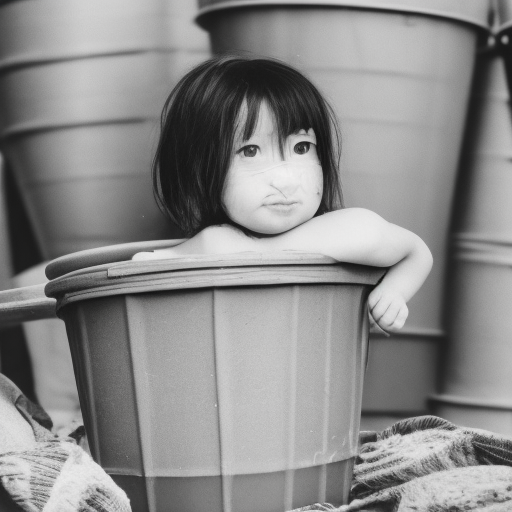

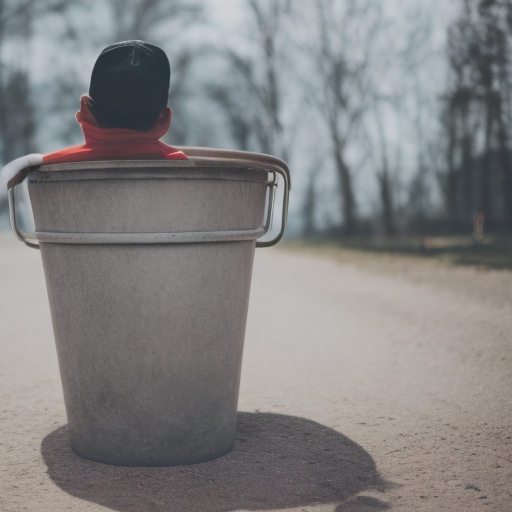

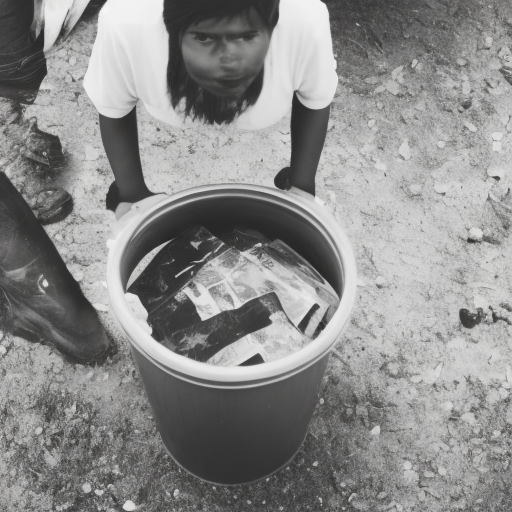

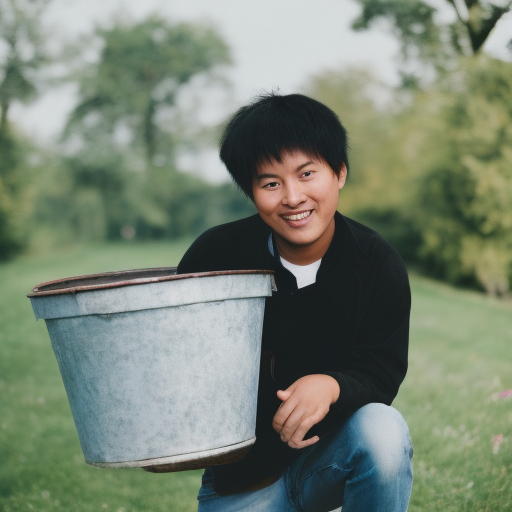

In [7]:
#Run for generating images.
prompt = "photo of SK person in a bucket"
negative_prompt = ""
num_samples = 4
guidance_scale = 7.5
num_inference_steps = 24
height = 512
width = 512

with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

for img in images:
    display(img)

In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 84.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 8.9 MB/s

In [ ]:
#Run Gradio UI for generating images.
import gradio as gr

def inference(prompt, negative_prompt, num_samples, height=512, width=512, num_inference_steps=50, guidance_scale=7.5):
    with torch.autocast("cuda"), torch.inference_mode():
        return pipe(
                prompt, height=int(height), width=int(width),
                negative_prompt=negative_prompt,
                num_images_per_prompt=int(num_samples),
                num_inference_steps=int(num_inference_steps), guidance_scale=guidance_scale,
                generator=g_cuda
            ).images

with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column():
            prompt = gr.Textbox(label="Prompt", value="photo of zwx dog in a bucket")
            negative_prompt = gr.Textbox(label="Negative Prompt", value="")
            run = gr.Button(value="Generate")
            with gr.Row():
                num_samples = gr.Number(label="Number of Samples", value=4)
                guidance_scale = gr.Number(label="Guidance Scale", value=7.5)
            with gr.Row():
                height = gr.Number(label="Height", value=512)
                width = gr.Number(label="Width", value=512)
            num_inference_steps = gr.Slider(label="Steps", value=24)
        with gr.Column():
            gallery = gr.Gallery()

    run.click(inference, inputs=[prompt, negative_prompt, num_samples, height, width, num_inference_steps, guidance_scale], outputs=gallery)

demo.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://16c7f0fc80178b72e0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


  0%|          | 0/24 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://16c7f0fc80178b72e0.gradio.live


## 7. Free memory

In [ ]:
exit()